In [9]:
import functools as ft
import os
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from scipy import constants
from tqdm.notebook import tqdm

from ising.config import Config, JaxPlatform
from ising.modules import AutocorrelationData
from ising.primitives.autocorrelate import acf
from ising.primitives.utils import beta_to_temp
from ising.state import Environment, Measurement, State
from ising.types import Algorithm
from ising.typing import RNGKey
from ising.utils.pbar import make_scan
from ising.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
assert os.cpu_count() == 96

In [11]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [12]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: Algorithm = Algorithm.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.50
TEMP_MAX: float = 1.50
N_TEMPS: int = 96

In [13]:
if not PAPERMILL:
    ...
    JAX_PLATFORM = JaxPlatform.TPU
    ALGORITHM = Algorithm.WOLFF
    N_TEMPS = 48
#     TOTAL_SAMPLES = N_TEMPS
#     DIMENSIONS = 4
#     TEMP_MIN = 6.0
#     TEMP_MAX = 6.8
#     SIZE = 24

In [14]:
# Post init
SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

if PAPERMILL:
    with open(SAVE_PATH / "config.json", "w") as f:
        f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

In [15]:
# Init
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
k = EasyKey(rng_seed)
rng_key = k.new

ENVIRONMENT_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    "algorithm": c.algorithm,
    "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

# CPU: Many cores, parallelise on temperatures
match c.jax_platform:
    case JaxPlatform.CPU:
        N_DEVICE_SAMPLES = 1
        PARALLELISE_TEMPERATURES = True

    case JaxPlatform.TPU:
        N_DEVICE_SAMPLES = device_count()
        PARALLELISE_TEMPERATURES = False

    case _:
        raise ValueError("Configuration error!")

N_SUBSAMPLES = c.total_samples // (N_DEVICE_SAMPLES * c.n_temps)

VECTORISATION_SHAPE = (N_DEVICE_SAMPLES, N_SUBSAMPLES, c.n_temps)
VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps

BETA_MIN = 1.0 / c.temp_max
BETA_MAX = 1.0 / c.temp_min
betas = np.geomspace(BETA_MIN, BETA_MAX, c.n_temps)


def transforms(in_axes, out_axes=0):
    def inner(fun):
        fun = eqx.filter_jit(fun)

        if PARALLELISE_TEMPERATURES:
            # BETAS
            fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

            # N_DEVICES
            fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        else:
            # BETAS
            fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

            # N_DEVICES
            fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

        # SUBSAMPLES
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


print(f"Temperatures: {c.n_temps:_}")
print(f"Vectorised count: {VECTORISED_COUNT:_}")
print(f"{c.n_temps=}")
print(f"{N_DEVICE_SAMPLES=}")
print(f"{N_SUBSAMPLES=}")
print(f"Total sweeps: {TOTAL_SWEEPS:_}")
assert VECTORISED_COUNT != 0

Temperatures: 48
Vectorised count: 384
c.n_temps=48
N_DEVICE_SAMPLES=8
N_SUBSAMPLES=1
Total sweeps: 960_000


In [16]:
# Single state
env = Environment.from_spin(spin=c.spin, beta=1.0, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=c.dimensions, size=c.size, env=env, id_=0
)

# state = state.evolve_steps(1000, rng_key=k.new)
initial_state = state
state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
# measured = state.measure(rng_key=k.new, num=1, sweeps=10)

state.calculate_energy()
state.calculate_magnetisation_density()

Array(-0.00292969, dtype=float32)

# Thermalisation

In [17]:
@transforms(in_axes=(0, None, None, None, 0, 0, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    spin: float,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    kwargs: dict[str, Any],
    num_prints: int = 10,
):
    # Make state
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=state_key, dimensions=dimensions, size=size, env=env, id_=id_
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(tqdm=tqdm, num_prints=num_prints)
    # scan = lax.scan
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


shape = (N_DEVICE_SAMPLES, N_SUBSAMPLES, *betas.shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=N_DEVICE_SAMPLES,
    subsamples=N_SUBSAMPLES,
)

# rng_key: RNGKey
# spin: float
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 25
states, evolve_measurements = make_and_thermalise_states(
    state_keys,
    c.spin,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    ENVIRONMENT_BASE_PARAMS,
    thermalise_num_prints,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = evolve_meas_df.explode(evolve_meas_df.columns.tolist())


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


evolve_meas_df["beta"] = evolve_meas_df["state_id"].apply(id_to_beta)
evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

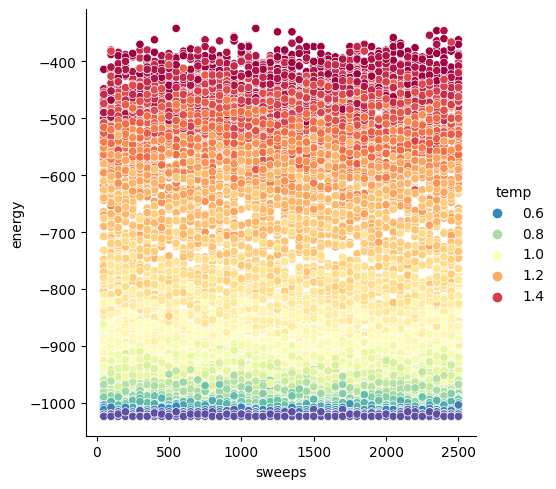

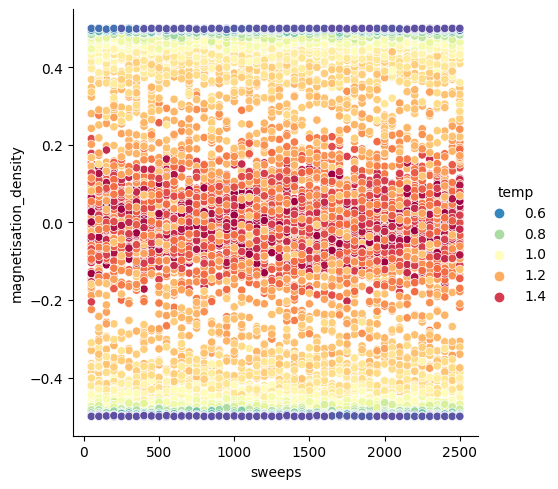

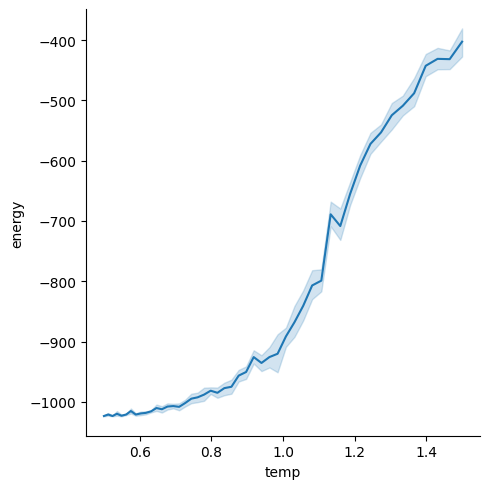

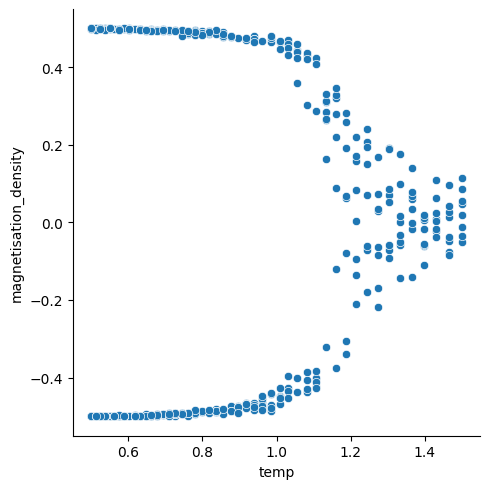

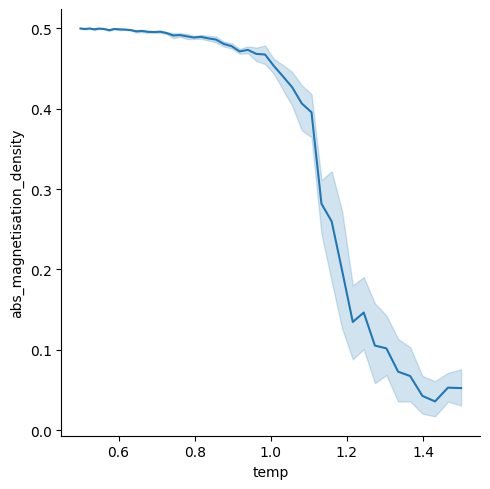

In [19]:
sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]
sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)

# Autocorrelation

In [20]:
@transforms(in_axes=(0, 0, None, None), out_axes=0)
def get_autocorrelation(
    key: RNGKey, state: State, steps: int, sweeps_per_step: int
) -> AutocorrelationData:
    keys = random.split(key, num=steps)

    def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
        rng_key = x
        state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    scan = make_scan(tqdm=tqdm, num_prints=10)
    state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

    acorr_energy = acf(measurements.energy)
    acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

    sweeps = np.arange(acorr_energy.size) * sweeps_per_step

    # Fit exponential decay to find characteristic autocorrelation time
    def exponential_decay(x, tau):
        """
        f(x) = exp(- x / τ)
        """
        return jnp.exp(-x / tau)

    # Objective function to minimise
    def objective(params, x, y):
        tau = params
        trial = exponential_decay(x, tau)
        residuals = y - trial

        return jnp.sum(residuals**2)

    initial_params = jnp.asarray([1.0])
    energy_decay_time = minimize(
        objective,
        x0=initial_params,
        method="BFGS",
        args=(
            sweeps,
            acorr_energy,
        ),
    ).x[0]
    mag_dens_decay_time = minimize(
        objective,
        x0=initial_params,
        method="BFGS",
        args=(
            sweeps,
            acorr_mag_dens,
        ),
    ).x[0]

    return AutocorrelationData(
        state=state,
        steps=steps,
        sweeps_per_step=sweeps_per_step,
        sweeps=sweeps,
        energy=acorr_energy,
        magnetisation_density=acorr_mag_dens,
        energy_decay_time=energy_decay_time,
        magnetisation_density_decay_time=mag_dens_decay_time,
    )


keys = k.shaped(states.vectorisation_shape)
ac_data = get_autocorrelation(keys, states, 100, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
ac_df = ac_data.to_df()
ac_df["temp"] = beta_to_temp(ac_df["state.env.beta"], human=True)
ac_df_expl = ac_df.explode(["energy", "magnetisation_density", "sweeps"])
display(ac_df)
display(ac_df_expl)

,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.dim,state.env.spin_states,state.env.beta,...,state.env.interaction_anisotropy,state.env.interaction_bicubic,state.env.interaction_external_field,state.env.nuclear_magnetic_moment,state.env.algorithm,state.env.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.8970091, 0.7889986, 0.72121555, 0.6584...","[0.99999994, 0.8146883, 0.64928967, 0.524281, ...",7.565440,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.500000
1,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.91601586, 0.8531843, 0.7909389, 0.7243...","[1.0, 0.87122166, 0.7420732, 0.64120513, 0.631...",13.158793,9.905622,2,"(-0.5, 0.5)",0.682433,...,0.0,0.0,0.0,1.0,wolff,False,1,35453,2600,1.465345
2,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9999999, 0.91738427, 0.8455084, 0.76043904,...","[1.0, 0.60395944, 0.4722617, 0.3028694, 0.1710...",7.399465,2.992772,2,"(-0.5, 0.5)",0.698573,...,0.0,0.0,0.0,1.0,wolff,False,2,39899,2600,1.431490
3,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.8933743, 0.8115852, 0.7303617, 0.64769...","[1.0, 0.8354371, 0.70643914, 0.5907944, 0.4922...",6.565985,5.771318,2,"(-0.5, 0.5)",0.715094,...,0.0,0.0,0.0,1.0,wolff,False,3,49896,2600,1.398417
4,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.99999994, 0.9302253, 0.8776681, 0.82316184,...","[1.0, 0.7743888, 0.6105886, 0.46694624, 0.3549...",16.845150,3.398915,2,"(-0.5, 0.5)",0.732006,...,0.0,0.0,0.0,1.0,wolff,False,4,56233,2600,1.366109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.99999994, -0.06283489, 0.034960307, -0.0200...","[1.0, -0.0737968, 0.034415998, -0.033223774, -...",0.065644,0.064815,2,"(-0.5, 0.5)",1.821478,...,0.0,0.0,0.0,1.0,wolff,False,379,2655294,2600,0.549005
380,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.99999994, -0.041941628, -0.051844597, 0.095...","[1.0, -0.025322294, -0.03949043, 0.106408656, ...",0.065898,0.069517,2,"(-0.5, 0.5)",1.864556,...,0.0,0.0,0.0,1.0,wolff,False,380,2657041,2600,0.536321
381,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.99999994, -0.07944828, 0.02731032, 0.098206...","[1.0, -0.07879805, 0.029895693, 0.115103886, -...",0.063294,0.065803,2,"(-0.5, 0.5)",1.908653,...,0.0,0.0,0.0,1.0,wolff,False,381,2655412,2600,0.523930
382,100,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, -0.016889967, 0.071321495, -0.10168408, ...","[1.0, -0.030780733, 0.07862403, -0.066856556, ...",0.074911,0.070073,2,"(-0.5, 0.5)",1.953793,...,0.0,0.0,0.0,1.0,wolff,False,382,2656112,2600,0.511825


,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.dim,state.env.spin_states,state.env.beta,...,state.env.interaction_anisotropy,state.env.interaction_bicubic,state.env.interaction_external_field,state.env.nuclear_magnetic_moment,state.env.algorithm,state.env.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,100,1,0,1.0,1.0,7.56544,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.5
0,100,1,1,0.897009,0.814688,7.56544,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.5
0,100,1,2,0.788999,0.64929,7.56544,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.5
0,100,1,3,0.721216,0.524281,7.56544,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.5
0,100,1,4,0.658436,0.418934,7.56544,4.153172,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,wolff,False,0,30468,2600,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,100,1,16,-0.109973,-0.104434,0.33369,0.287975,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,wolff,False,383,2657369,2600,0.5
383,100,1,17,-0.023009,-0.01418,0.33369,0.287975,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,wolff,False,383,2657369,2600,0.5
383,100,1,18,-0.073695,-0.077506,0.33369,0.287975,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,wolff,False,383,2657369,2600,0.5
383,100,1,19,-0.036315,-0.041524,0.33369,0.287975,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,wolff,False,383,2657369,2600,0.5


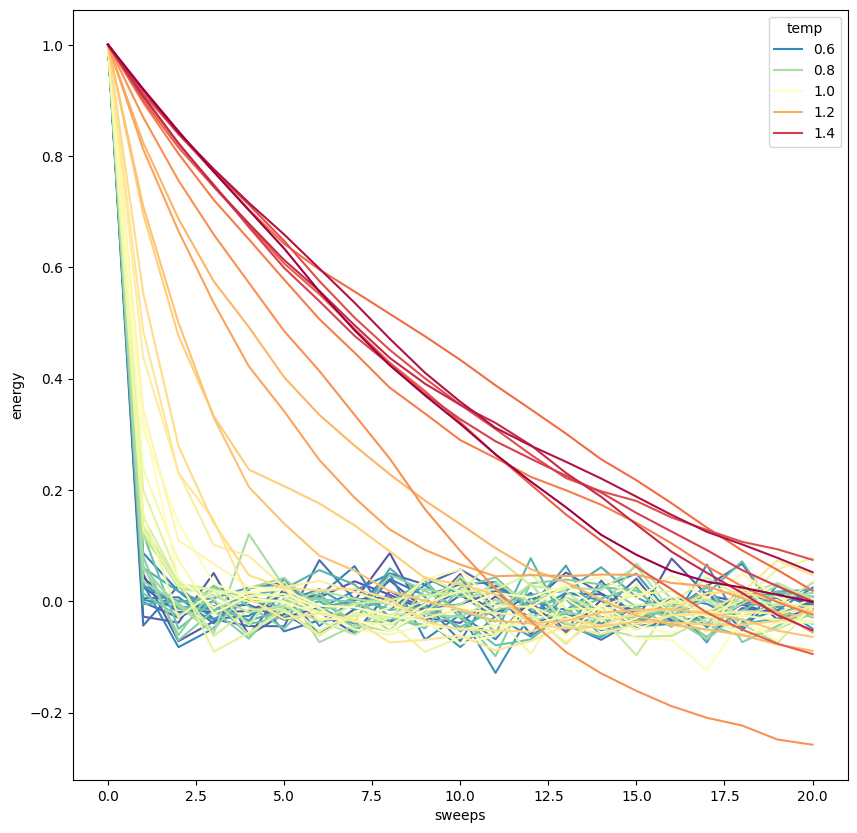

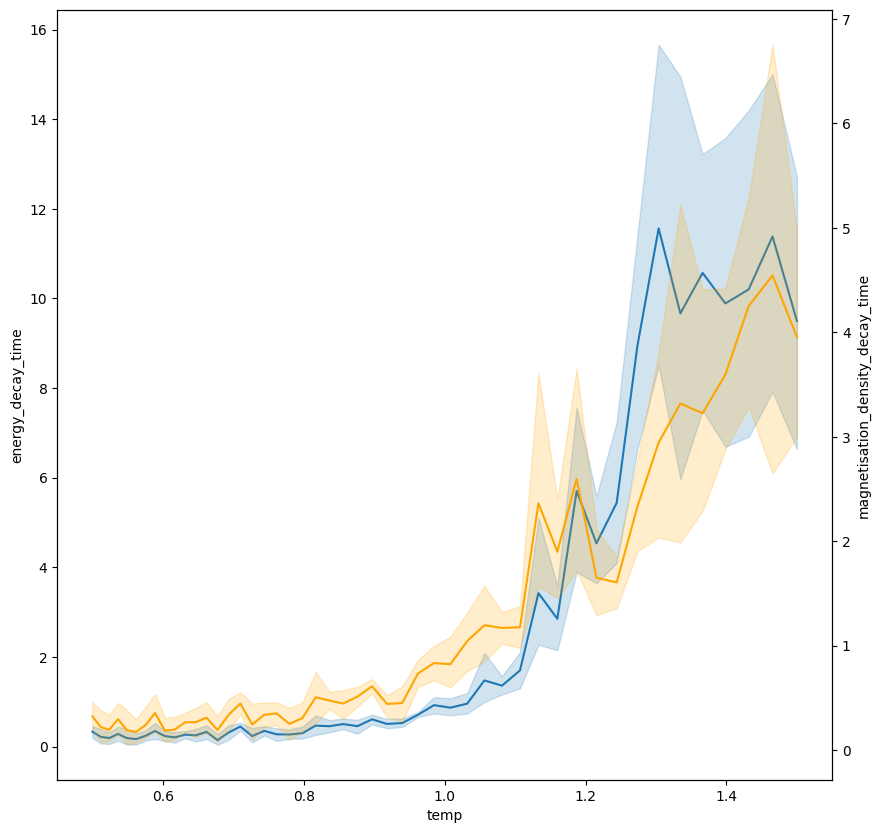

In [22]:
sns.lineplot(
    data=ac_df_expl,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
    errorbar=None,
)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(
    data=ac_df,
    x="temp",
    y="energy_decay_time",
    ax=ax1,
    # y=["energy_decay_time", "magnetisation_density_decay_time"])
)
sns.lineplot(
    data=ac_df,
    x="temp",
    y="magnetisation_density_decay_time",
    ax=ax2,
    color="orange",
    # y=["energy_decay_time", "magnetisation_density_decay_time"])
)
plt.show()

In [23]:
states_list = states.unensamble()
temp_states = states_list[: c.n_temps]

In [24]:
@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.set_size_inches(10, 10)
    fig.dpi = 100


...

interactive(children=(IntSlider(value=23, description='i', max=47), Output()), _dom_classes=('widget-interact'…

Ellipsis

In [25]:
@eqx.filter_vmap(in_axes=(0, None, None))
def evolve_and_measure(rng_key: RNGKey, state: State, sweeps: int) -> Measurement:
    state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps)
    measurement = state.measure()

    return measurement


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_equilibrium(
    key: RNGKey, state: State, steps: int, num: int, sweeps: int
) -> Measurement:
    def body_fun(carry, x):
        _rng_key = x
        _keys = random.split(_rng_key, num=num)

    make_scan(tqdm=tqdm, num_prints=10)

NameError: name 'in_axes' is not defined

In [ ]:
keys = k.shaped(states.vectorisation_shape)


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_equilibrium(key: RNGKey, state: State, steps: int, num: int, sweeps: int):
    return state.evolve_and_measure_multiple(rng_key=key, num=num, sweeps=sweeps)


equil_measurements = measure_equilibrium(keys, states, 16, 50)

In [ ]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
eq_measurements = {key: [] for key in measurement_keys}
for key in measurement_keys:
    data = getattr(equil_measurements, key).flatten().tolist()
    eq_measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


eq_df = pd.DataFrame(eq_measurements)
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = 1.0 / eq_df["beta"]
eq_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature
0,10444800,2550,0,-1724.0,0.010986,0.666667,1.5
1,10444800,2550,0,-1734.0,0.050049,0.666667,1.5
2,10444800,2550,0,-1886.0,0.023193,0.666667,1.5
3,10444800,2550,0,-1702.0,-0.007080,0.666667,1.5
4,10444800,2550,0,-1716.0,-0.023438,0.666667,1.5
...,...,...,...,...,...,...,...
6139,10444800,2550,383,-4086.0,-0.499268,2.000000,0.5
6140,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5
6141,10444800,2550,383,-4080.0,-0.499023,2.000000,0.5
6142,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5


In [ ]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states


sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()


# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df["state_id"] = sum_df.index

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = 1.0 / sum_df["beta"]

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(
    np.gradient(sum_df["energies_mean"], sum_df["temperature"])
)
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(
    np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"])
)
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()


# mag_2_mean = np.mean(mag_2)
# mag_4_mean = np.mean(mag_4)

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (
    3.0 * np.square(sum_df["mag_2_mean"])
)

In [ ]:
sum_df

,energies_mean,energies_var,mag_dens_mean,mag_dens_var,state_id,beta,temperature,natural_temperature,heat_cap_gradient,heat_cap_fluctuation,mag_sus_gradient,mag_sus_fluctuation,mag_1_mean,mag_2_mean,mag_4_mean,binder_2,binder_4
state_id,,,,,,,,,,,,,,,,,
0,-1693.125,6334.916667,-0.009811,1.243386e-03,0,9.204327e-24,1.086446e+23,1.086446e+23,2.871933e-20,3.887243e-20,3.896666e-24,7.629690e-27,0.030624,0.001262,2.855758e-06,-3.455606e-01,-2.644225e-01
1,-1729.000,2484.266667,-0.014679,4.208157e-04,1,9.311386e-24,1.073954e+23,1.073954e+23,1.458213e-20,1.560068e-20,2.114673e-24,2.642636e-27,0.019531,0.000610,1.185465e-06,-5.990430e-01,-7.286729e-01
2,-1729.750,3922.066667,-0.004730,4.850457e-04,2,9.419691e-24,1.061606e+23,1.061606e+23,1.369194e-20,2.520606e-20,4.910450e-24,3.117258e-27,0.018951,0.000477,4.870135e-07,-3.284065e-01,-3.798334e-01
3,-1762.250,4491.133333,-0.002533,5.533288e-04,3,9.529256e-24,1.049400e+23,1.049400e+23,2.787597e-20,2.953865e-20,1.918790e-24,3.639301e-27,0.019562,0.000525,5.545613e-07,-3.723876e-01,-3.369252e-01
4,-1797.375,4221.183333,-0.000076,6.827412e-04,4,9.640095e-24,1.037334e+23,1.037334e+23,2.965066e-20,2.841277e-20,1.012153e-24,4.595528e-27,0.021011,0.000640,1.252484e-06,-4.498507e-01,-6.857002e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-4086.375,28.383333,-0.499405,1.189609e-07,379,2.636477e-23,3.792941e+22,3.792941e+22,4.419015e-21,1.428986e-21,2.955054e-25,5.989203e-30,0.499405,0.249405,6.220315e-02,-4.471673e-07,-5.959660e-07
380,-4088.375,25.716667,-0.499527,9.909272e-08,380,2.667143e-23,3.749330e+22,3.749330e+22,1.259019e-21,1.325025e-21,6.794419e-26,5.105651e-30,0.499527,0.249527,6.226396e-02,-3.723018e-07,-4.964830e-07
381,-4087.500,63.200000,-0.499466,2.401570e-07,381,2.698166e-23,3.706222e+22,3.706222e+22,1.351248e-21,3.332507e-21,9.168313e-26,1.266337e-29,0.499466,0.249466,6.223374e-02,-9.025159e-07,-1.202604e-06


In [ ]:
sin_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,natural_temperature,abs_magnetisation_density,mag_1,mag_2,mag_4
0,10444800,2550,0,-1724.0,0.010986,0.666667,1.5,1.5,0.010986,0.010986,0.000121,1.456835e-08
1,10444800,2550,0,-1734.0,0.050049,0.666667,1.5,1.5,0.050049,0.050049,0.002505,6.274450e-06
2,10444800,2550,0,-1886.0,0.023193,0.666667,1.5,1.5,0.023193,0.023193,0.000538,2.893707e-07
3,10444800,2550,0,-1702.0,-0.007080,0.666667,1.5,1.5,0.007080,0.007080,0.000050,2.512767e-09
4,10444800,2550,0,-1716.0,-0.023438,0.666667,1.5,1.5,0.023438,0.023438,0.000549,3.017485e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
6139,10444800,2550,383,-4086.0,-0.499268,2.000000,0.5,0.5,0.499268,0.499268,0.249268,6.213459e-02
6140,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5,0.5,0.499512,0.499512,0.249512,6.225622e-02
6141,10444800,2550,383,-4080.0,-0.499023,2.000000,0.5,0.5,0.499023,0.499023,0.249024,6.201315e-02
6142,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5,0.5,0.499512,0.499512,0.249512,6.225622e-02


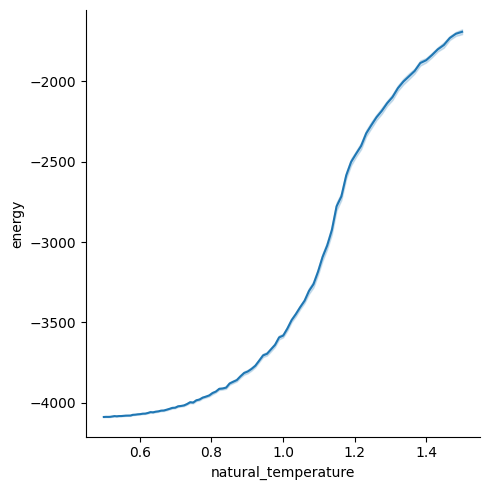

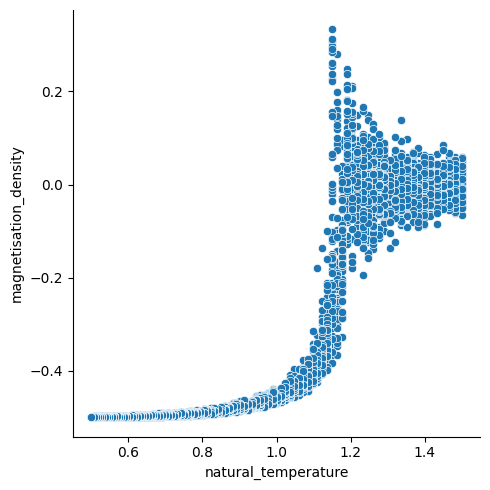

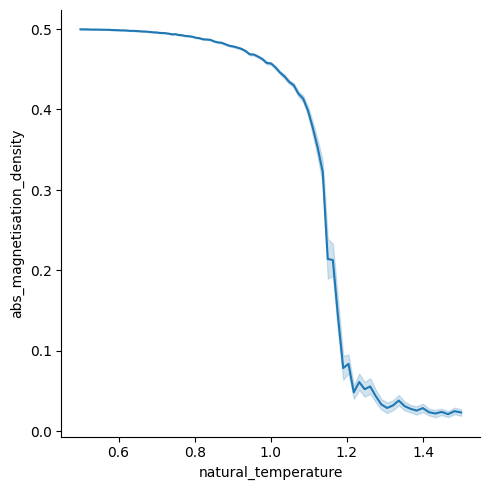

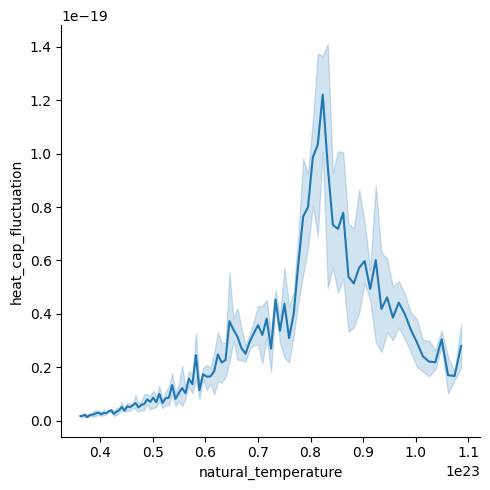

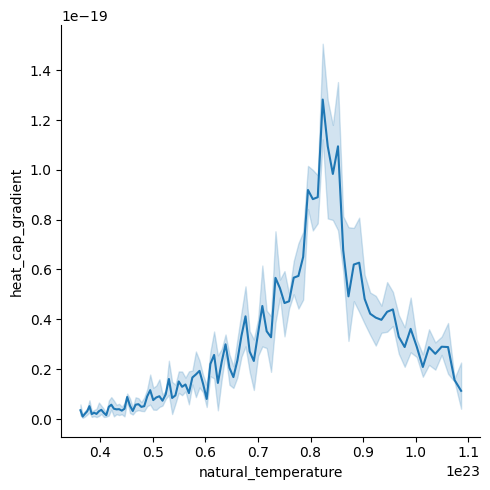

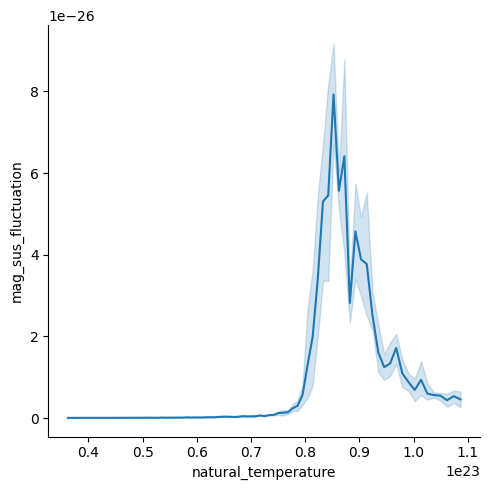

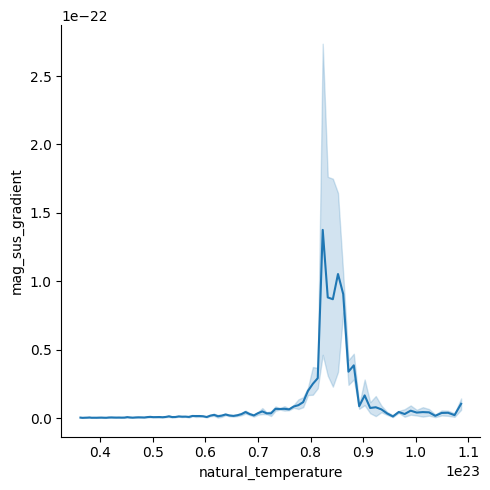

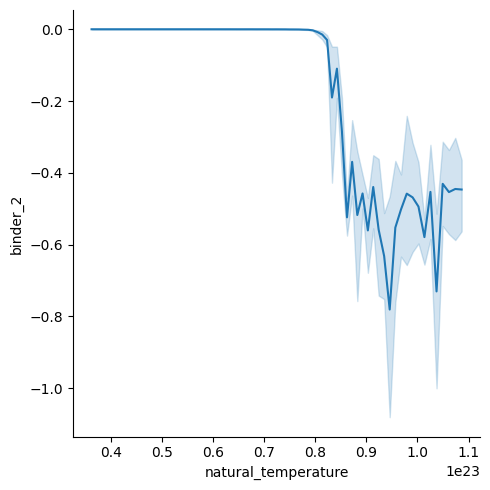

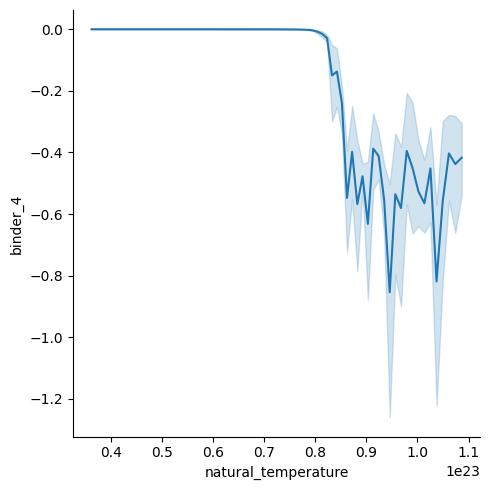

In [ ]:
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="magnetisation_density",
    # kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    kind="line",
)